In [ ]:
# Choose your fighters
import PyPDF2
import os
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer, util
from unicodedata import normalize
import re
import csv 
from string2string.alignment import SmithWaterman
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pkg_resources
from symspellpy import SymSpell, Verbosity
import pkg_resources

cwd = os.getcwd()
model = SentenceTransformer('all-MiniLM-L6-v2')
sw = SmithWaterman(
    match_weight=2, # weight for a match
    mismatch_weight=-1, # weight for a mismatch
    gap_weight=0, # weight for a gap
    gap_char='-' # character to use for a gap
)

# load a dictionary (this one consists of 82,765 English words)
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1) # count_index: column of term's frequency, term_index: column of term

# Pairwise Semantic Similarity & S-W Local Alignment
**Output csv:** paragraph1, paragraph2, semantic_similarity, overlap_similarity, bill1, bill2

In [41]:
def symspell_corrector(input_term):
  # Look up suggestions for multi-word input strings 
  suggestions = sym_spell.lookup_compound( 
      phrase=input_term,  
      max_edit_distance=2,  
      transfer_casing=True,  
      ignore_term_with_digits=False, 
      ignore_non_words=True, 
      split_by_space=True 
  ) 
  # Implement the correction
  for suggestion in suggestions: 
      return f"{suggestion.term}"

def extract_and_sec_split(filepath):
    _, extension = os.path.splitext(filepath)
    with open(filepath, "rb") as file:
        if extension == ".pdf":
            reader = PyPDF2.PdfReader(file, strict=False)
            text = ""
            for page_num in range(len(reader.pages)):
                page = reader.pages[page_num]
                text += page.extract_text()
        elif extension == ".html":
            soup = BeautifulSoup(file, "html.parser")
            text = soup.get_text(strip=True)
        else:
            raise ValueError(f"{filepath}: Unsupported file format")

        text = normalize('NFKD', text).lower()
        text = re.sub(r'\r\n', ' ', text)
        text = re.sub(r'§', 'section', text)
        text = re.sub(r'[^a-zA-Z.;:\']', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = symspell_corrector(text)

    sections = []
    for section in re.split(r'section', text):
        # if len(section) > 8:
        sections.append(section)
    return sections

In [42]:
bills = {}
subdir = os.path.join(cwd, "bills")

for bill in os.listdir(subdir):
    filename, extension = os.path.splitext(bill)
    if extension == ".pdf" or extension == ".html":
        data = extract_and_sec_split(os.path.join(subdir, bill))
        bills[filename] = data
        

In [43]:
bills

{'NV-AB375': ['reprinted with amendments adopted on april first reprint a by abr assembly bill not assemblywoman cooling march joint sponsor a senator hammond referred to committee on education summary revises certain provisions concerning public schools bar fiscal note effect on local government may have fiscal impact effect on the state yes explanation matter in folded italics is new matter between brackets omitted material is material to be omitted an act relating to education providing certain requirements for school facilities that are designated for use by persons of one biological sex and providing other matters properly relating thereto legislative counsels digest ',
  ' of this bill requires that any school facility in a public school including a restroom locker room or shower which is designated for use by persons of one biological sex must only be used by persons of that biological sex as determined at birth ',
  ' also requires a public school to provide separate private ar

In [ ]:
# Compute pairwise semantic similarity and local alignment 
num_bills = len(bills)
cherry = []

# Iterate through bill sections
for i, (name_i, sect_i) in enumerate(bills.items()):
    # Iterate through bills sections
    for j, (name_j, sect_j) in enumerate(bills.items()):
        # Skip if comparing the same bill
        if i != j:
            # Compare each section from bill i with each section from bill j
            for section_i in sect_i:
                for section_j in sect_j:
                    # Calculate embeddings and cosine similarity
                    embeddings = model.encode([section_i, section_j])
                    cos_score = util.cos_sim(embeddings[0].reshape(1, -1), embeddings[1].reshape(1, -1))[0][0]
                    
                    # Calculate normalized Smith-Waterman score
                    sw_score = sw.get_alignment_score(section_i, section_j)

                    # Store vals in array
                    cherry.append([section_i, section_j, float(cos_score), sw_score, name_i, name_j])

for item in cherry:
    print(f"Cosine Similarity: {item[2]}, Normalized S-W Score: {item[3]}")
    print(f"{item[4]}: {item[0]}")
    print(f"{item[5]}: {item[1]}")
    print("-" * 50)

In [314]:
# Export to CSV
date="1019"
with open(f'cherry-{date}.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(cherry)

# RESULTS

In [ ]:
col_names = ["paragraph1", "paragraph2", "semantic_similarity", "overlap_similarity", "bill1", "bill2"] 
df = pd.read_csv(f"cherry-{date}.csv", names=col_names, header=None)

In [56]:
print(df.shape)
df.head()

(22006, 6)


,paragraph1,paragraph2,semantic_similarity,overlap_similarity,bill1,bill2
0,84 r hb 2801 introduced version bill text84r13...,session of 2016 house bill no. 2737 by committ...,0.565017,0.794521,TX-HB2801,KS-HB2737
1,84 r hb 2801 introduced version bill text84r13...,1. the provisions of,0.304578,0.727273,TX-HB2801,KS-HB2737
2,84 r hb 2801 introduced version bill text84r13...,s 1 through 7 and amendments thereto shall be ...,0.611206,0.752066,TX-HB2801,KS-HB2737
3,84 r hb 2801 introduced version bill text84r13...,s 1 through 7 and amendments thereto: a sex me...,0.572227,0.690083,TX-HB2801,KS-HB2737
4,84 r hb 2801 introduced version bill text84r13...,a 2 where a student may be in a state of undr...,0.627844,0.764463,TX-HB2801,KS-HB2737


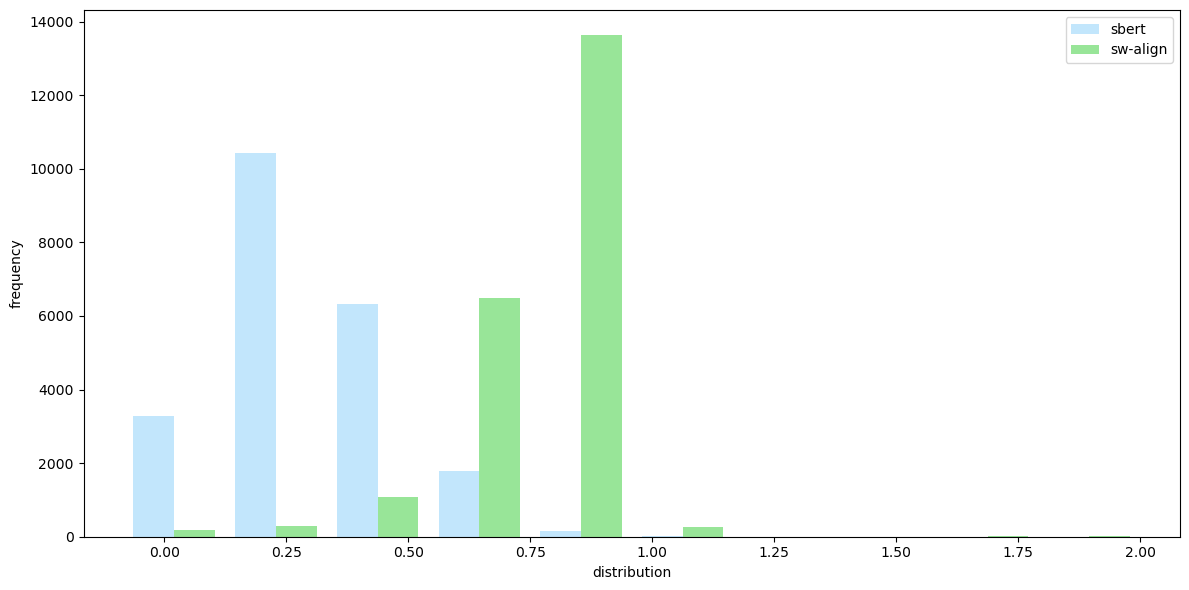

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.hist([df["semantic_similarity"], df["overlap_similarity"]], color=['lightskyblue','limegreen'], label=['sbert','sw-align',], 
         linewidth=0, alpha=0.5)

ax.legend()
plt.xlabel("distribution")
plt.ylabel("frequency")
plt.tight_layout()
plt.show();

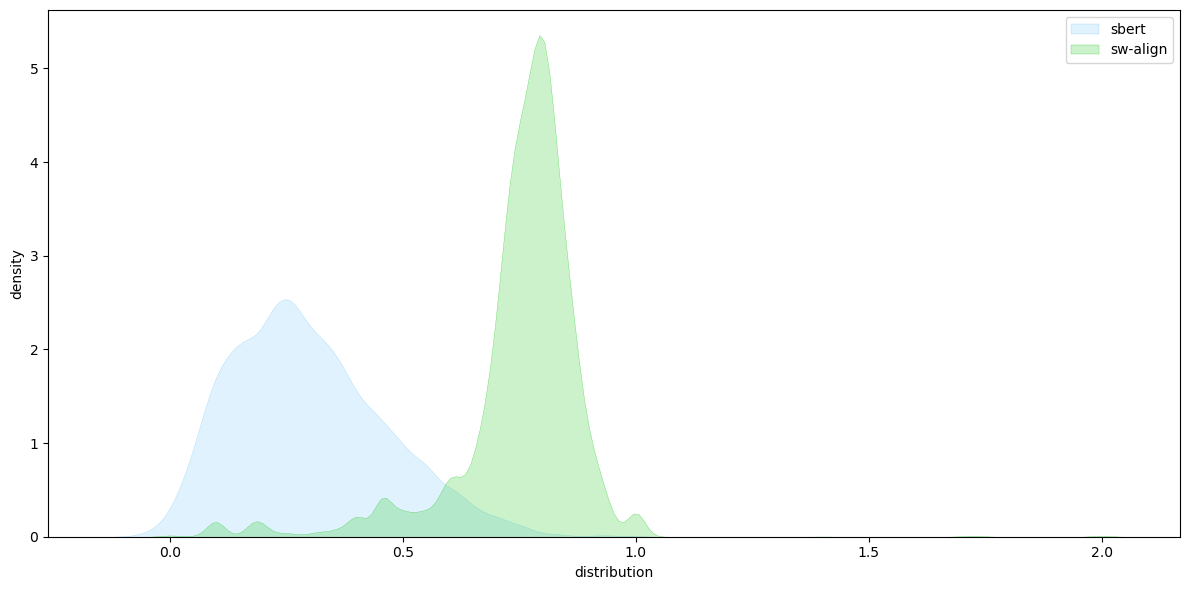

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=df["semantic_similarity"],
            color='lightskyblue', label='sbert', fill=True, ax=ax, linewidth=.2)
sns.kdeplot(data=df["overlap_similarity"],
            color='limegreen', label='sw-align', fill=True, ax=ax, linewidth=.2)
ax.legend()
plt.xlabel("distribution")
plt.ylabel("density")
plt.tight_layout()
plt.show()

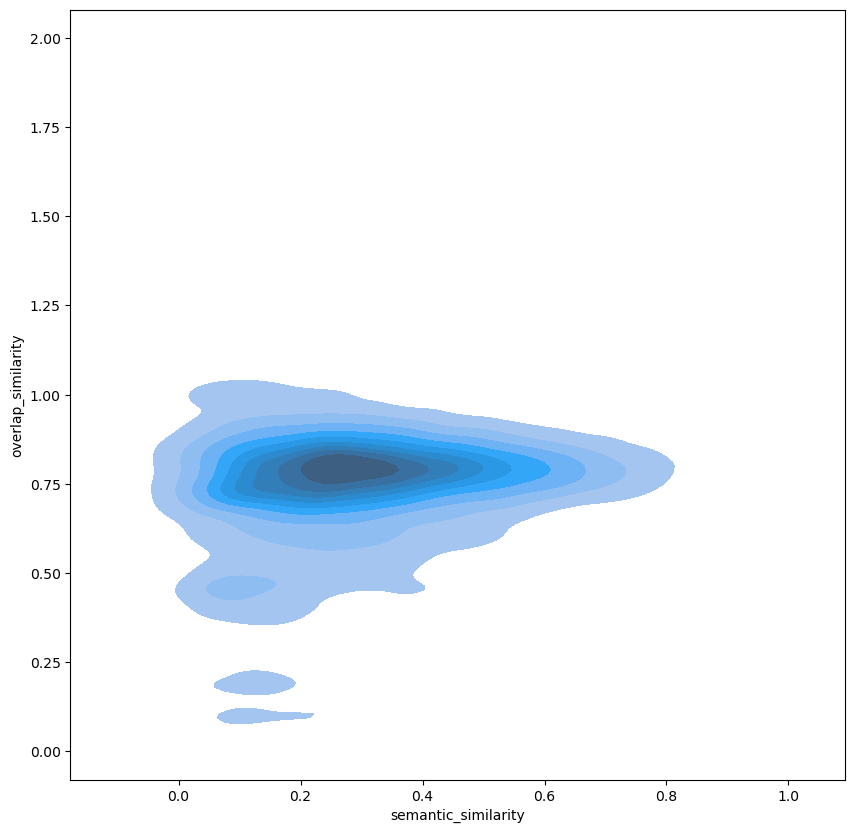

In [60]:
plt.figure(figsize=(10, 10))
sns.kdeplot(data=df, x="semantic_similarity", y="overlap_similarity", fill=True);
plt.show()